In [3]:
import torch
import numpy as np
import random
torch.manual_seed(23336666)
np.random.seed(23336666)
random.seed(23336666)

kaggle = False
if kaggle:
    !pip install ../input/facenet-pytorch-vggface2/facenet_pytorch-2.0.1-py3-none-any.whl
    !pip install ../input/dfdc-model/codes/pkgs/efficientnet_pytorch-0.6.1/efficientnet_pytorch-0.6.1

import sys, os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
import time
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from torchvision.transforms import Normalize, RandomHorizontalFlip, ToTensor, ToPILImage, Compose, Resize
from sklearn.metrics import log_loss
import pathlib
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from hashlib import sha1

 
if kaggle:
    codes_path = "/kaggle/input/dfdc-model/codes/"    
else:
    codes_path = "/home/kailu/deepfake/"
    
sys.path += [codes_path+"pkgs", codes_path+"utils"]
blaze_weight = codes_path+"pkgs/blazeface.pth"
anchors = codes_path+"pkgs/anchors.npy"
from engine import FaceInferenceModel, BlazeFace_extractor, FastDataset, show, Cache_loader, MTCNN_extractor

In [171]:
import albumentations as aug
from numpy.random import choice
trans = [aug.Downscale(0.5, 0.5, p=1), aug.JpegCompression(quality_lower=20, quality_upper=20, p=1), aug.Flip(p=0)]

def augment(imgs, do_augment=True):
    if np.random.randint(3) < 2 and not kaggle and do_augment:
        tran = choice(trans)
        imgs = np.array([tran(**{"image":img})["image"] for img in imgs])
    return imgs

filenames = glob.glob('/home/lthpc/test_videos/*.mp4')
face_extractor = MTCNN_extractor(factor=0.5)
ds = FastDataset(filenames, sample_rate = 13)
loader = DataLoader(ds, batch_size=1, num_workers=10, drop_last=False, shuffle=False)

all_face = []
dropped_face = []

frame_cnt = 0
for batch in loader:
    frames = augment(batch[0].data.numpy(), True)
    img_size = frames.shape[1] * frames.shape[2]
    faces = face_extractor.get_faces(frames, only_one=False)
    for frame in faces:
        frame_cnt += 1
        
        drops = []
        if len(frame)>=2:
            frame = sorted(frame, key = lambda x: x.prob)
            if frame[-1].prob - 0.05 > frame[-2].prob:
                drops = frame[:-1]
                frame = frame[-1:]
            else:
                drops = frame[:-2]
                frame = frame[-2:]
        
        for face in frame:
            all_face.append((Image.fromarray(face.face), (face.box[2]-face.box[0])*(face.box[3]-face.box[1])/img_size, face.prob, frame_cnt, 0))
        
        for face in drops:
            all_face.append((Image.fromarray(face.face), (face.box[2]-face.box[0])*(face.box[3]-face.box[1])/img_size, face.prob, frame_cnt, 1))
        
face_df = pd.DataFrame(all_face, columns=["image","size","prob", "img_id", "drop"])

In [172]:
face_df["extra"] = np.sqrt(face_df["size"])/np.exp(face_df["prob"])
face_df = face_df.sort_values("extra")

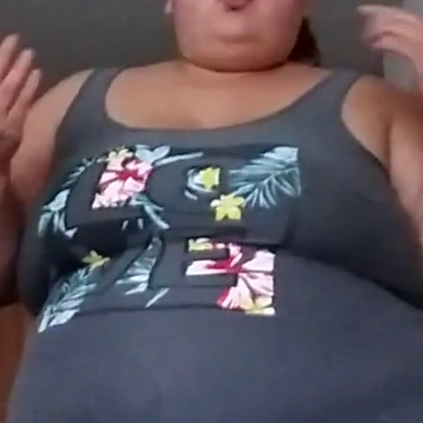

In [182]:
face_df.at[2634,"image"]

In [170]:
face_df[face_df["img_id"]==1733]

,image,size,prob,img_id,extra
1839,<PIL.Image.Image image mode=RGB size=76x76 at ...,0.002785,0.986957,1733,0.019671
1838,<PIL.Image.Image image mode=RGB size=182x182 a...,0.015974,0.999621,1733,0.046514
1837,<PIL.Image.Image image mode=RGB size=223x223 a...,0.023982,0.999954,1733,0.056973


In [173]:
face_df

,image,size,prob,img_id,drop,extra
3719,<PIL.Image.Image image mode=RGB size=77x77 at ...,0.002859,0.980972,3462,1,0.020049
2318,<PIL.Image.Image image mode=RGB size=77x77 at ...,0.002859,0.907595,2123,1,0.021576
370,<PIL.Image.Image image mode=RGB size=70x70 at ...,0.002363,0.774610,378,1,0.022404
3375,<PIL.Image.Image image mode=RGB size=82x82 at ...,0.003243,0.922331,3134,0,0.022641
919,<PIL.Image.Image image mode=RGB size=69x69 at ...,0.002296,0.749304,896,1,0.022650
4241,<PIL.Image.Image image mode=RGB size=89x89 at ...,0.003820,0.990472,3925,0,0.022955
2313,<PIL.Image.Image image mode=RGB size=73x73 at ...,0.002570,0.772899,2121,1,0.023404
3007,<PIL.Image.Image image mode=RGB size=85x85 at ...,0.003484,0.921830,2782,0,0.023481
622,<PIL.Image.Image image mode=RGB size=94x94 at ...,0.004261,0.999850,629,0,0.024018
1619,<PIL.Image.Image image mode=RGB size=75x75 at ...,0.002713,0.771554,1527,1,0.024078
